# Heart attack analysis. Building a classification model

We have data on patients seen by a cardiologist. The main goal of this notebook is to build a machine learning model, that will be able to predict the risk of a heart attack based on a patient's health condition.

Here we have the description of the features:

1. *age* - age in years

2. *sex* - sex (0 = female; 1 = male)

3. *cp* - chest pain type (1 = typical angina; 2 = atypical angina; 3 = non-anginal pain; 0 = asymptomatic)

4. *trtbps* - resting blood pressure (in mm Hg on admission to the hospital)

5. *chol* - serum cholestoral in mg/dl

6. *fbs* - fasting blood sugar > 120 mg/dl (0 = false; 1 = true)

7. *restecg* - resting electrocardiographic results (0 = normal; 1 = hypertrophy; 2 = having ST-T wave abnormality)

8. *thalachh* - maximum heart rate achieved

9. *exng* - exercise induced angina (0 = no; 1 = yes)

10. *oldpeak* - ST depression induced by exercise relative to rest

11. *slp* - the slope of the peak exercise ST segment (0 = downsloping; 1 = flat; 2 = upsloping)

12. *caa* - number of major vessels (0-4) colored by flourosopy

13. *thall* - thallium stress test (1 = fixed defect; 2 = reversable defect; 3 = normal)

14. **output** - 0 = less chance of heart attack; 1 = more chance of heart attack

## First look at the data

First of all, let's import the libraries we'll need

In [756]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform
from scipy.stats import loguniform
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from catboost import CatBoostClassifier

Now we can upload the dataset and have a look at it.

In [125]:
df = pd.read_csv('heart.csv')

In [126]:
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


1. The dataset includes information about 303 patients.
2. There are 13 features. Even though 12 of them are integer type, only 6 are really numerical, the rest are categorical.
3. The target is *output*. 0 is low risk patient, 1 is high risk patient.
4. There are no missing values.

## EDA

Before we go to the modeling part we have to get a closer look at our data to get insights into the problem.

### Distribtuions

In this section, we will get an idea about our patients by considering all the features separately

#### Age

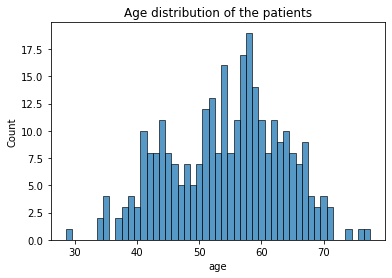

In [128]:
sns.histplot(df.age, discrete=True)
plt.title('Age distribution of the patients')
plt.show()

The dataset contains information about older patients, which is to be expected. The majority of the patients are older than 40. The distribution tends to be normal distribution. The peak is at 57-58 years old.

#### Gender

In [129]:
df.sex.value_counts().to_frame()

,sex
1,207
0,96


We have 2 times more males than females.

#### Chest pain type

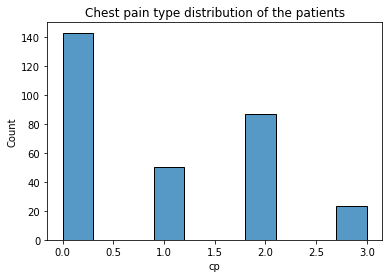

In [130]:
sns.histplot(df.cp)
plt.title('Chest pain type distribution of the patients')
plt.show()

Almost a half of the patients have no pain in the chest.

#### Resting blood pressure

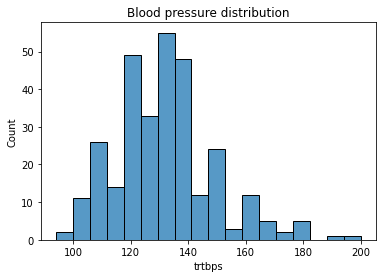

In [131]:
sns.histplot(df.trtbps)
plt.title('Blood pressure distribution')
plt.show()

The distribution has a peak at a value of approx. 135. The highest blood pressure is about 200. 

According to the [European Society of Cardiology](https://www.escardio.org/), the following classification for blood pressure is applied:

| Category | Blood pressure |
| :------- | :------------- |
| Optimal | < 120 |	
| Normal | 120–129 |	
| High normal |	130–139 |	
| Grade 1 hypertension | 140–159 |	
| Grade 2 hypertension | 160–179 |
| Grade 3 hypertension | ≥ 180 |

#### Cholesterol

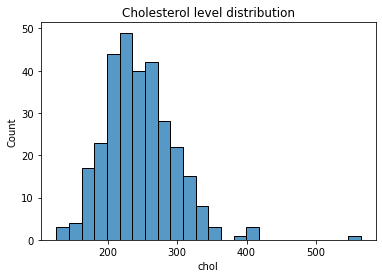

In [132]:
sns.histplot(df.chol)
plt.title('Cholesterol level distribution')
plt.show()

The distribution has a normal shape, but it's skewed to the right because of the outliers. Some patients have an extremely high level of cholesterol.

Let's have a look at the boxplot.

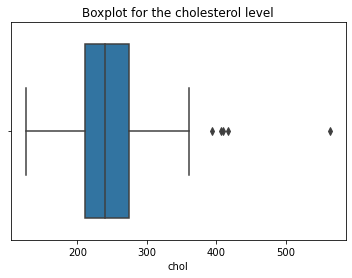

In [133]:
sns.boxplot(data=df, x='chol')
plt.title('Boxplot for the cholesterol level')
plt.show()

Yes, the cholesterol is higher than approx. 360 can be considered as outliers. But we can not delete them, because it's realistic values.

The following interpretation of cholesterol level is usually used (this information was taken from [wikipedia](https://en.wikipedia.org/wiki/Hypercholesterolemia):

| Cholesterol, mg/dl | Interpretation |
| :----------------- | :------------- |
| < 200 | Desirable |
| 200-239 | Borderline |
| > 240 | High |

#### Fasting blood sugar

Reminder: 0 means less or equal to 120 mg/dl (which is good), 1 means higher than 120 mg/dl.

In [134]:
df.fbs.value_counts().to_frame()

,fbs
0,258
1,45


The majority of the patients don't have serious sugar problems.

#### Resting electrocardiographic results

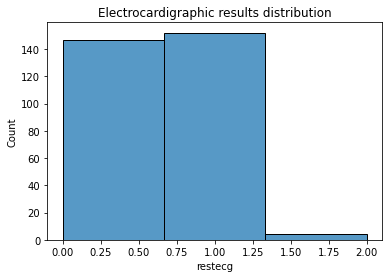

In [135]:
sns.histplot(df.restecg, bins=3)
plt.title('Electrocardigraphic results distribution')
plt.show()

About 50% of the patients have hypertrophy. Only a few of the patients have ST-T wave abnormality. The rest of them have normal results. 

#### Maximum heart rate achieved

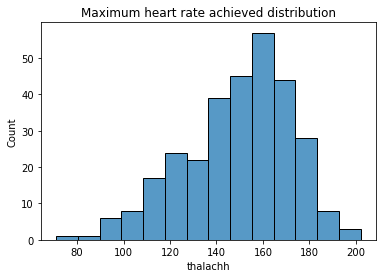

In [136]:
sns.histplot(df.thalachh)
plt.title('Maximum heart rate achieved distribution')
plt.show()

The distribtuion looks similar to normal distrubtion. It's skewed a bit to the left.

The maximum heart rate (MHR) is the highest heart rate an individual can achieve without severe problems through exercise stress and generally decreases with age. It can be estimated using Tanaka's formula (men and women over age 40): 

$$ MHR = 208 - (0.7 \times age)$$. 

Let's have a look at how many patients have their maximum heart rate achieved is higher than the estimated one.

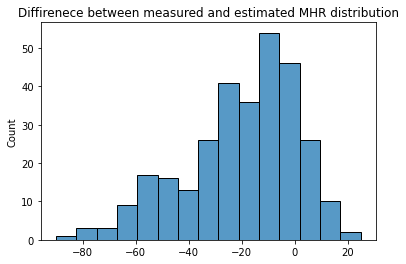

In [137]:
sns.histplot(df.thalachh - (208 - (0.7 * df.age)))
plt.title('Diffirenece between measured and estimated MHR distribution')
plt.show()

The majority of the patients have measured MHR lower than estimated. 

#### Exercise-induced angina

In [138]:
df.exng.value_counts().to_frame()

,exng
0,204
1,99


Almost one-third of the patients have exercise-induced angina. 

#### ST depression induced by exercise relative to rest

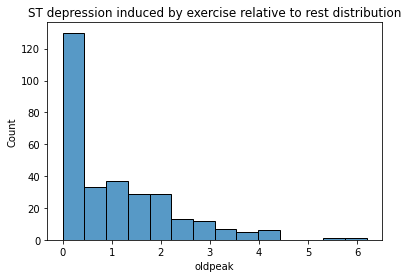

In [139]:
sns.histplot(df.oldpeak)
plt.title('ST depression induced by exercise relative to rest distribution')
plt.show()

The narrow peak is at 0. The distribution is skewed to the right.

#### The slope of the peak exercise ST segment

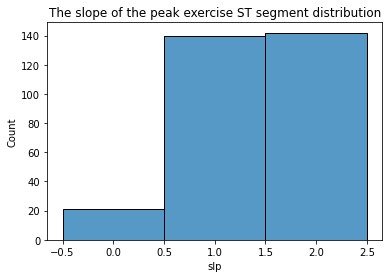

In [140]:
sns.histplot(df.slp, discrete=True)
plt.title('The slope of the peak exercise ST segment distribution')
plt.show()

#### Number of major vessels

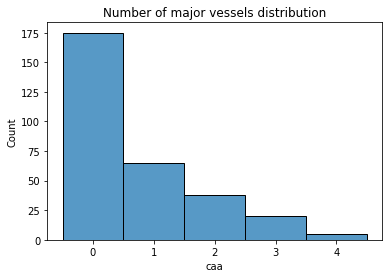

In [141]:
sns.histplot(df.caa, discrete=True)
plt.title('Number of major vessels distribution')
plt.show()

More than a half of the patients do not have major vessels.

#### Thallium stress test

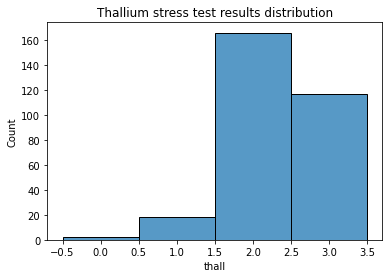

In [142]:
sns.histplot(df.thall, discrete=True)
plt.title('Thallium stress test results distribution')
plt.show()

More than 50% of the patients have normal results. One weird thing is observed. We have patients that have "0", but there is no information about this label in the feature description. Let's have a look at these rows.

In [143]:
df.query('thall == 0')

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
48,53,0,2,128,216,0,0,115,0,0.0,2,0,0,1
281,52,1,0,128,204,1,1,156,1,1.0,1,0,0,0


There is nothing strange. We can consider these cells as missing values. Let's fill them by using KNN imputer.

In [144]:
df['thall'] = df['thall'].replace({0 : np.nan})

In [145]:
imputer = KNNImputer()
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
df['thall'] = df['thall'].round()

#### The chance of heart attack

In [146]:
df.output.value_counts().to_frame()

,output
1.0,165
0.0,138


In [147]:
df.output.value_counts(normalize=True).to_frame()

,output
1.0,0.544554
0.0,0.455446


54.5% of the patients have a high risk of heart attack, 45.5% - low risk of a heart attack. The classes are relatively balanced. So, in the future, we won't have to worry about the disbalance.

### Influence on the target

In this section, we'll consider how the features affects the target.

Since the target is a categorical variable, it doesn't make any sense to apply correlation analysis. We will check the influence of the features on the target by comparing distributions for high risk of heart attack (labeled "1") and for low risk of heart attack (labeled "0").  

#### Numerical variables

Let's build a distribution for each of the numerical values depending on the target value. 

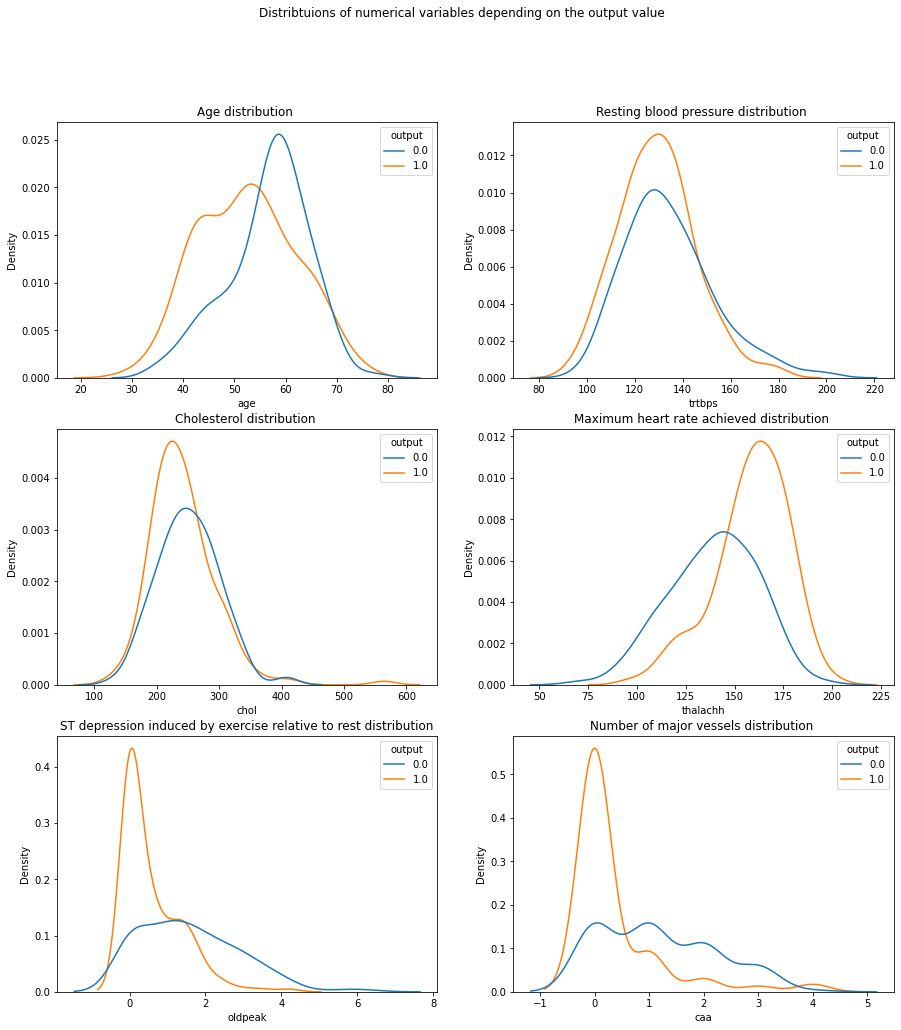

In [148]:
_, axes = plt.subplots(3, 2, figsize=(15,16))
sns.kdeplot(data=df, x='age', hue='output', ax=axes[0, 0])
axes[0, 0].set_title('Age distribution ')
sns.kdeplot(data=df, x='trtbps', hue='output', ax=axes[0, 1])
axes[0, 1].set_title('Resting blood pressure distribution ')
sns.kdeplot(data=df, x='chol', hue='output', ax=axes[1, 0])
axes[1, 0].set_title('Cholesterol distribution ')
sns.kdeplot(data=df, x='thalachh', hue='output', ax=axes[1, 1])
axes[1, 1].set_title('Maximum heart rate achieved distribution ')  
sns.kdeplot(data=df, x='oldpeak', hue='output', ax=axes[2, 0])
axes[2, 0].set_title('ST depression induced by exercise relative to rest distribution')
sns.kdeplot(data=df, x='caa', hue='output', ax=axes[2, 1])
axes[2, 1].set_title('Number of major vessels distribution ')
plt.suptitle('Distribtuions of numerical variables depending on the output value')
plt.show()

- From the distributions, it can be observed that cholesterol level and blood pressure do not affect the chance of heart attack.
- Another interesting observation is that relatively younger people more prone to have a heart attack.
- Maximum heart rate achieved, ST depression induced by exercise relative to rest, and number of major vessels have an ifluence on the output.

#### Categorical variables

Since we have almost balanced classes, it will be convenient to use pie plot for comparison.

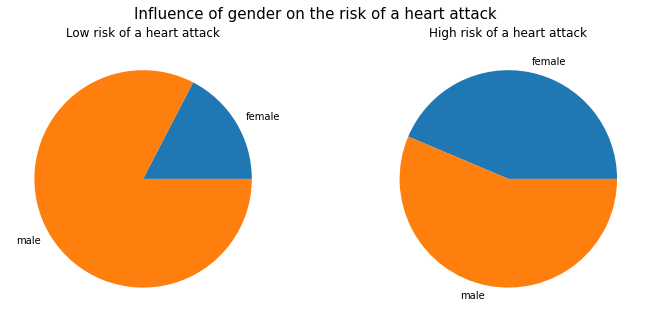

In [1138]:
_, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].pie(df.query('output == 0').groupby('sex')['sex'].count(), labels=['female', 'male'])
axes[0].set_title('Low risk of a heart attack')
axes[1].pie(df.query('output == 1').groupby('sex')['sex'].count(), labels=['female', 'male'])
axes[1].set_title('High risk of a heart attack')
plt.suptitle('Influence of gender on the risk of a heart attack', fontsize=15)
plt.show()

In [150]:
df.groupby('output', as_index=False)['sex'].mean()

,output,sex
0,0.0,0.826087
1,1.0,0.563636


- Among low-risk patients, males account for 82.6%, while among high-risk patients they percentage is lower (56.4%). From that, we can conclude than women are more prone to heart disease.

Let's consider chest pain type.

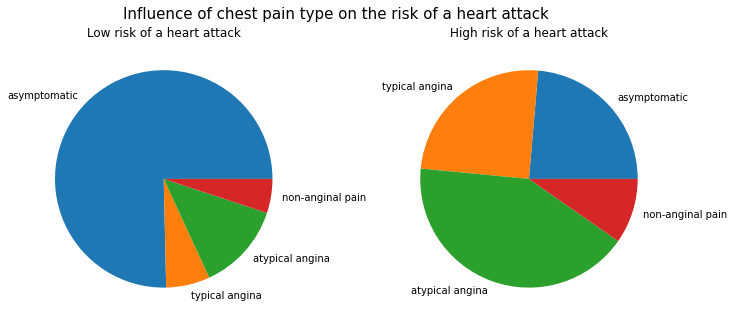

In [1137]:
_, axes = plt.subplots(1, 2, figsize=(12,5)) 

labels = ['asymptomatic', 'typical angina', 'atypical angina', 'non-anginal pain']

axes[0].pie(df.query('output == 0').groupby('cp')['cp'].count(), labels=labels)
axes[0].set_title('Low risk of a heart attack')
axes[1].pie(df.query('output == 1').groupby('cp')['cp'].count(), labels=labels)
axes[1].set_title('High risk of a heart attack')
plt.suptitle('Influence of chest pain type on the risk of a heart attack', fontsize=15)
plt.show()

- From these charts, we can conclude that patients with any type of chest pain are more likely to be in the risk group.

Let's move on to the blood sugar.

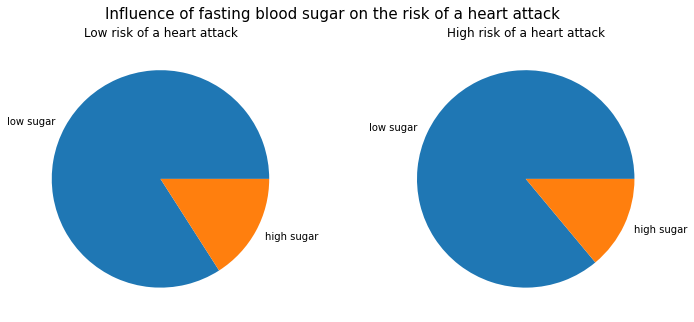

In [1136]:
_, axes = plt.subplots(1, 2, figsize=(12,5))
labels = ['low sugar', 'high sugar']

axes[0].pie(df.query('output == 0').groupby('fbs')['fbs'].count(), labels=labels)
axes[0].set_title('Low risk of a heart attack')
axes[1].pie(df.query('output == 1').groupby('fbs')['fbs'].count(), labels=labels)
axes[1].set_title('High risk of a heart attack')
plt.suptitle('Influence of fasting blood sugar on the risk of a heart attack', fontsize=15)
plt.show()

- Fasting blood sugar doesn't affect the output.

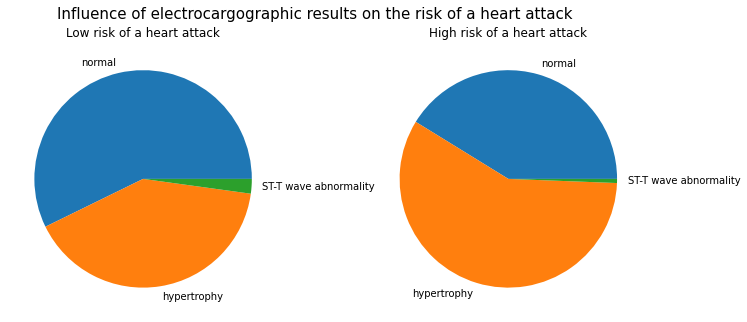

In [1135]:
_, axes = plt.subplots(1, 2, figsize=(12,5)) 

labels = ['normal', 'hypertrophy', 'ST-T wave abnormality']

axes[0].pie(df.query('output == 0').groupby('restecg')['restecg'].count(), labels=labels)
axes[0].set_title('Low risk of a heart attack')
axes[1].pie(df.query('output == 1').groupby('restecg')['restecg'].count(), labels=labels)
axes[1].set_title('High risk of a heart attack')
plt.suptitle('Influence of electrocargographic results on the risk of a heart attack', fontsize=15)
plt.show()

- People with hypertrophy are more prone to a heart attack.

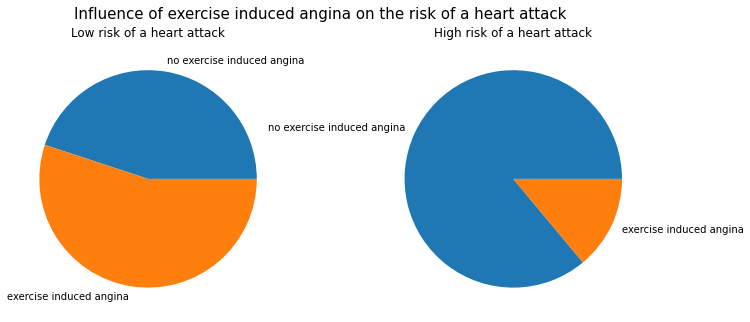

In [1134]:
_, axes = plt.subplots(1, 2, figsize=(12,5))
labels = ['no exercise induced angina', 'exercise induced angina']

axes[0].pie(df.query('output == 0').groupby('exng')['exng'].count(), labels=labels)
axes[0].set_title('Low risk of a heart attack')
axes[1].pie(df.query('output == 1').groupby('exng')['exng'].count(), labels=labels)
axes[1].set_title('High risk of a heart attack')
plt.suptitle('Influence of exercise induced angina on the risk of a heart attack', fontsize=15)
plt.show()

- The high risk group contains significantly fewer people with exercise induced angina.

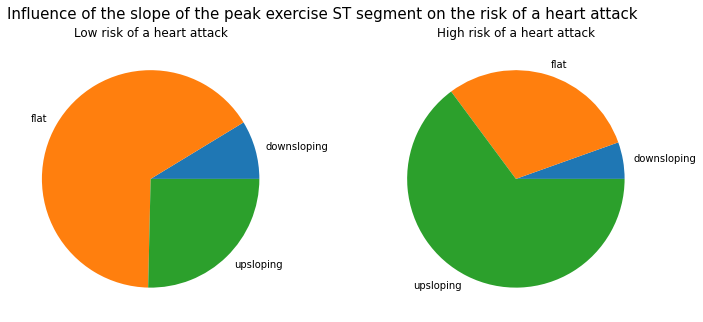

In [1131]:
_, axes = plt.subplots(1, 2, figsize=(12,5))
labels = ['downsloping', 'flat', 'upsloping']

axes[0].pie(df.query('output == 0').groupby('slp')['slp'].count(), labels=labels)
axes[0].set_title('Low risk of a heart attack')
axes[1].pie(df.query('output == 1').groupby('slp')['slp'].count(), labels=labels)
axes[1].set_title('High risk of a heart attack')
plt.suptitle('Influence of the slope of the peak exercise ST segment on the risk of a heart attack', fontsize=15)
plt.show()

- People with a positive slope have a higher chance of a heart attack. 

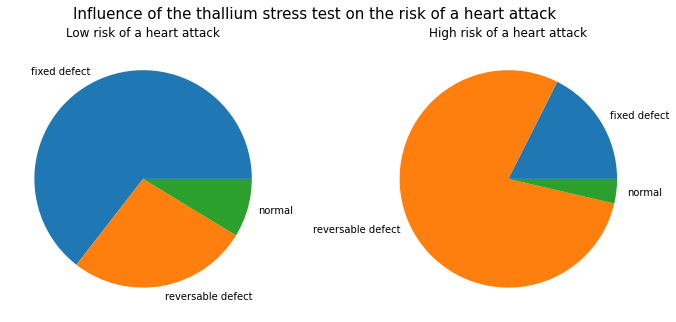

In [1132]:
_, axes = plt.subplots(1, 2, figsize=(12,5))
labels = ['fixed defect', 'reversable defect', 'normal']

axes[0].pie(df.query('output == 0').groupby('thall')['thall'].count(), labels=labels)
axes[0].set_title('Low risk of a heart attack')
axes[1].pie(df.query('output == 1').groupby('thall')['thall'].count(), labels=labels)
axes[1].set_title('High risk of a heart attack')
plt.suptitle('Influence of the thallium stress test on the risk of a heart attack', fontsize=15)
plt.show()

- Thallium stress test results affect the chance to be in the risk group. People with normal results are less prone to a heart attack.

Out dataset is built the way when the low categorical value means a good condition, and high categorical value means a bad condition (*exng* is equal to 0 when no angina, *restecg* is equal to 0 when normal results). Only one exception is *thall* feature. Let's change this by mapping.

In [157]:
df['thall'] = df['thall'].map({3 : 0, 1 : 2, 2 : 1})

Now we have the following labels:
- 0 = normal
- 1 = reversable defect
- 2 = fixed defect

4 of our categorical features (*cp*, *restecg*, *exng*, and *thall*) can be considered as analyzes with relatively simple interpretation for us. And taking into account the encoding system, the lower the value - the better the health condition.
So we can assume that combination of these parameters can affect the target. For example, let's check the patients that have the best health condition based on these features.

In [158]:
df.query('cp == 0 and restecg == 0 and exng == 0 and thall == 0')['output'].value_counts()

0.0    13
Name: output, dtype: int64

All of them are not in the risk group.

Speaking informally, we can combine these features by simply summarizing them. And then check distributions for the different outputs.

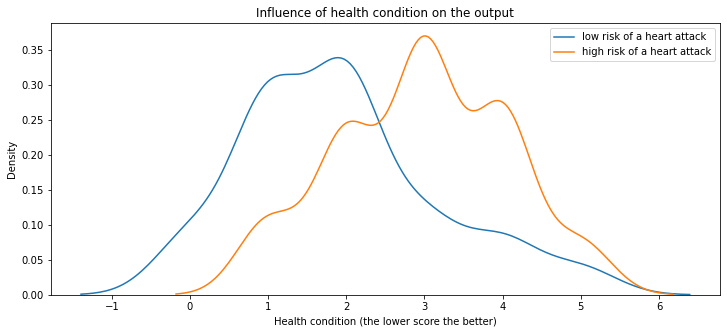

In [1139]:
plt.figure(figsize=(12,5))
df_0 = df.query('output == 0')
df_1 = df.query('output == 1')
sns.kdeplot(df_0.cp + df_0.restecg + df_0.exng + df_0.thall, label='low risk of a heart attack')
sns.kdeplot(df_1.cp + df_1.restecg + df_1.exng + df_1.thall, label='high risk of a heart attack')
plt.title('Influence of health condition on the output')
plt.xlabel('Health condition (the lower score the better)')
plt.legend()
plt.show()

The conclusion is that people with good health condition has a lower chance to a heart attack.

### Conclusions

1. The majority of the patients are older than 40. 
2. In the dataset there are 2 times more males than females.
3. 54.5% of the patients have a high risk of heart attack, 45.5% - low risk of a heart attack. The classes are relatively balanced. 
4. The following numerical features affect the output: age, maximum heart rate achieved, ST depression induced by exercise relative to rest distribution, and the number of major vessels.
5. All categorical features, except fasting blood sugar, affect the output.
6. Age distribution of patients from the high-risk group has a peak at 50-52 ages.
7. Women are more prone to a heart attack than men.
8. Patients that have normal analysis results (such as electrocardiography or thallium stress test) are less likely to have a heart attack.

## Feature engineering

In this paragraph, based on carried out EDA, we will try to build new features that can help us to predict the output.

Let's make a copy of the original dataframe to be able to compare two sets of features.

In [160]:
df_new = df.copy()

### Removing the features

Let's start with removing useless features. From the previous section, we assume that blood pressure, cholesterol and blood sugar have no influence on a heart attack. To check we'll use attribute *feature_importnaces_* from RandomForestClassifier.

In [161]:
rf_classifier = RandomForestClassifier(max_depth=8,
                                       n_estimators=100,
                                       random_state=42)
rf_classifier.fit(df.drop('output', axis=1), df['output'])

RandomForestClassifier(max_depth=8, random_state=42)

In [162]:
importance = pd.concat([pd.Series(df.columns[:-1]), 
                        pd.Series(rf_classifier.feature_importances_)], axis=1)
importance.columns = ['feature', 'importance']
importance = importance.sort_values(by='importance', ascending=False)
importance

,feature,importance
2,cp,0.143875
7,thalachh,0.125165
12,thall,0.109902
11,caa,0.109500
9,oldpeak,0.106870
0,age,0.081869
4,chol,0.073372
3,trtbps,0.072702
8,exng,0.059275
10,slp,0.051713


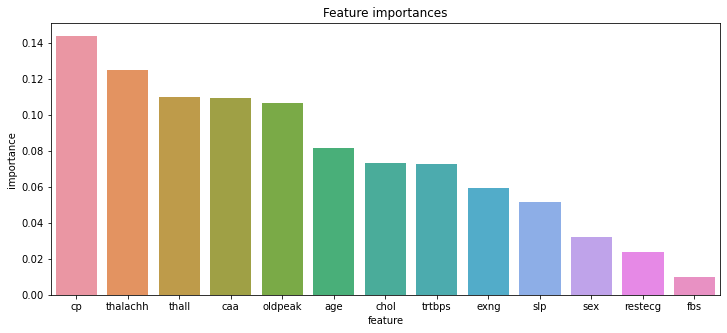

In [1140]:
plt.figure(figsize=(12,5))
sns.barplot(data=importance, x='feature', y='importance')
plt.title('Feature importances')
plt.show()

Only our assumption regarding blood sugar was confirmed. Let's remove the feature.

In [164]:
df_new = df_new.drop('fbs', axis=1)

Features *sex* and *restecg* have low importance, but during the EDA we could observe the opposite situation. Let's keep them in the dataframe.

### Adding new features

The feature, that has an influence on the output, is the maximum heart rate achieved. In medical practice it's calculated using the following equation:

$$ MHR = 208 - (0.7 \times age)$$

We can use it as a new feature.

In [165]:
df_new['mhr_estimation'] = 208 - 0.7 * df_new['age']

As it was discussed before, we can make a new categorical feature from blood pressure using the following label system:
- pressure < 120 = 0 (normal)
- 120 <= pressure < 140 = 1 (elevated)
- 140 <= pressure = 2 (high)

In [166]:
df_new['blood_pres_cat'] = df_new['trtbps'].apply(lambda x: 0 if x < 120 else (1 if x < 140 else 2))

In [167]:
df_new['blood_pres_cat'].value_counts().to_frame()

,blood_pres_cat
1,146
2,97
0,60


The same idea can be applied to the cholesterol level:
- cholesterol < 200 = 0 (desirable)
- 200 <= cholesterol < 240 = 1 (borderline)
- 240 <= cholesterol = 2 (high)

In [168]:
df_new['cholesterol_cat'] = df_new['chol'].apply(lambda x: 0 if x < 200 else (1 if x < 240 else 2))

In [169]:
df_new['cholesterol_cat'].value_counts().to_frame()

,cholesterol_cat
2,155
1,98
0,50


Also, we can make a feature that will characterize both of the last considered features. Let's simply summarize two categories. If a person has 0, it means that he has normal blood pressure and normal cholesterol. But if the value is 4, it means that he has high blood pressure and high cholesterol.

In [170]:
df_new['pres_chol_sum_cat'] = df_new['blood_pres_cat'] + df_new['cholesterol_cat']

In [171]:
df_new['pres_chol_sum_cat'].value_counts().to_frame()

,pres_chol_sum_cat
3,109
2,84
4,52
1,45
0,13


In the previous section we summed other categorical features and were able to observe the difference in the output. Let's do the same here. The interpretation of the feature is simple - the lower value the better person's health according to these tests. 

In [172]:
df_new['cat_sum'] = df_new['cp'] + df_new['restecg'] + df_new['exng'] + df_new['thall']

In [173]:
df_new['cat_sum'].value_counts().to_frame()

,cat_sum
2.0,85
3.0,73
1.0,60
4.0,54
5.0,18
0.0,13


**Eventually, 1 feature was removed, 5 features were added**

In [174]:
len(df_new.columns) - len(df.columns)

4

Let's have a look at the new dataframe.

In [175]:
df_new.head()

,age,sex,cp,trtbps,chol,restecg,thalachh,exng,oldpeak,slp,caa,thall,output,mhr_estimation,blood_pres_cat,cholesterol_cat,pres_chol_sum_cat,cat_sum
0,63.0,1.0,3.0,145.0,233.0,0.0,150.0,0.0,2.3,0.0,0.0,2,1.0,163.9,2,1,3,5.0
1,37.0,1.0,2.0,130.0,250.0,1.0,187.0,0.0,3.5,0.0,0.0,1,1.0,182.1,1,2,3,4.0
2,41.0,0.0,1.0,130.0,204.0,0.0,172.0,0.0,1.4,2.0,0.0,1,1.0,179.3,1,1,2,2.0
3,56.0,1.0,1.0,120.0,236.0,1.0,178.0,0.0,0.8,2.0,0.0,1,1.0,168.8,1,1,2,3.0
4,57.0,0.0,0.0,120.0,354.0,1.0,163.0,1.0,0.6,2.0,0.0,1,1.0,168.1,1,2,3,3.0


### Assessment of changes

Now we can compare the performance of two features sets on the simple model using cross-validation.

In [176]:
cross_val_score(
    estimator=RandomForestClassifier(max_depth=8,
                                     n_estimators=100,
                                     random_state=42),
    X=df.drop('output', axis=1),
    y=df['output'],
    scoring='f1',
    cv=5
).mean()

0.8495548242607066

In [177]:
cross_val_score(
    estimator=RandomForestClassifier(max_depth=8,
                                     n_estimators=100,
                                     random_state=42),
    X=df_new.drop('output', axis=1),
    y=df_new['output'],
    scoring='f1',
    cv=5
).mean()

0.8585580788082277

The performance of the new model with modified features is better.

### Conclusions

1. Feature *fbs* (fasting blood sugar) was removed.
2. One new numerical feature was added - estimated maximum heart rate achieved.
3. 4 new categorical features were added.

## Data preparation

Since there are no missing values in the data, the preparation is simple.

First of all, let's separate numerical and categorical features.

In [178]:
num_features = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak', 'caa', 'mhr_estimation']
cat_features = ['sex', 'cp', 'restecg', 'exng', 'slp', 'thall', 'blood_pres_cat', 'cholesterol_cat', 'pres_chol_sum_cat', 'cat_sum']

Now we can create the matrix of features and the dependent variable vector.

In [179]:
features = df_new.drop('output', axis=1)
target = df_new['output'].astype('int')

In [180]:
print(features.shape)
print(target.shape)

(303, 17)
(303,)


### Preparation for CatBoost

CatBoost is one of the most efficient gradient boosting libraries. 
According to the library documentation, it's not recommended to do data preparation beforehand (especially for categorical features, because CatBoost has its own built-in mechanisms to handle categorical features). Feature scaling also will be omitted. One thing we have to do is splitting the dataset.

In [799]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42) 

In [800]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(242, 17)
(61, 17)
(242,)
(61,)


To avoid any conflicts in the fiture we have to transform our categorical features to string type.

In [801]:
X_train[cat_features] = X_train[cat_features].astype('str')
X_test[cat_features] = X_test[cat_features].astype('str')

In [802]:
X_train.head()

,age,sex,cp,trtbps,chol,restecg,thalachh,exng,oldpeak,slp,caa,thall,mhr_estimation,blood_pres_cat,cholesterol_cat,pres_chol_sum_cat,cat_sum
132,42.0,1.0,1.0,120.0,295.0,1.0,162.0,0.0,0.0,2.0,0.0,1,178.6,1,2,3,3.0
202,58.0,1.0,0.0,150.0,270.0,0.0,111.0,1.0,0.8,2.0,0.0,0,167.4,2,2,4,1.0
196,46.0,1.0,2.0,150.0,231.0,1.0,147.0,0.0,3.6,1.0,0.0,1,175.8,2,1,3,4.0
75,55.0,0.0,1.0,135.0,250.0,0.0,161.0,0.0,1.4,1.0,0.0,1,169.5,1,2,3,2.0
176,60.0,1.0,0.0,117.0,230.0,1.0,160.0,1.0,1.4,2.0,2.0,0,166.0,0,1,1,2.0


In [803]:
X_test.head()

,age,sex,cp,trtbps,chol,restecg,thalachh,exng,oldpeak,slp,caa,thall,mhr_estimation,blood_pres_cat,cholesterol_cat,pres_chol_sum_cat,cat_sum
179,57.0,1.0,0.0,150.0,276.0,0.0,112.0,1.0,0.6,1.0,1.0,2,168.1,2,2,4,3.0
228,59.0,1.0,3.0,170.0,288.0,0.0,159.0,0.0,0.2,1.0,0.0,0,166.7,2,2,4,3.0
111,57.0,1.0,2.0,150.0,126.0,1.0,173.0,0.0,0.2,2.0,1.0,0,168.1,2,0,2,3.0
246,56.0,0.0,0.0,134.0,409.0,0.0,150.0,1.0,1.9,1.0,2.0,0,168.8,1,2,3,1.0
60,71.0,0.0,2.0,110.0,265.0,0.0,130.0,0.0,0.0,2.0,1.0,1,158.3,0,2,2,3.0


### Encoding categorical data

In the dataset, all categorical variables have been already encoded by label encoding. I don't find this a good idea. Let's use Ohe Hot Encoding.

In [804]:
features_ohe = pd.get_dummies(features, drop_first=True, columns=cat_features)

In [805]:
features_ohe.head()

,age,trtbps,chol,thalachh,oldpeak,caa,mhr_estimation,sex_1.0,cp_1.0,cp_2.0,...,cholesterol_cat_2,pres_chol_sum_cat_1,pres_chol_sum_cat_2,pres_chol_sum_cat_3,pres_chol_sum_cat_4,cat_sum_1.0,cat_sum_2.0,cat_sum_3.0,cat_sum_4.0,cat_sum_5.0
0,63.0,145.0,233.0,150.0,2.3,0.0,163.9,1,0,0,...,0,0,0,1,0,0,0,0,0,1
1,37.0,130.0,250.0,187.0,3.5,0.0,182.1,1,0,1,...,1,0,0,1,0,0,0,0,1,0
2,41.0,130.0,204.0,172.0,1.4,0.0,179.3,0,1,0,...,0,0,1,0,0,0,1,0,0,0
3,56.0,120.0,236.0,178.0,0.8,0.0,168.8,1,1,0,...,0,0,1,0,0,0,0,1,0,0
4,57.0,120.0,354.0,163.0,0.6,0.0,168.1,0,0,0,...,1,0,0,1,0,0,0,1,0,0


### Train-test split

Let's split the data into the training and test sets in the ratio 80/20.

In [806]:
features_train, features_test, target_train, target_test = train_test_split(features_ohe, 
                                                                            target, 
                                                                            test_size=0.2,
                                                                            random_state=42)

Let's check the shapes of the new objects.

In [807]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(242, 31)
(61, 31)
(242,)
(61,)


The split was performed successfully.

### Standardization

In [808]:
scaler = StandardScaler()
features_train[num_features] = scaler.fit_transform(features_train[num_features])
features_test[num_features] = scaler.transform(features_test[num_features])

In [809]:
features_train.head()

,age,trtbps,chol,thalachh,oldpeak,caa,mhr_estimation,sex_1.0,cp_1.0,cp_2.0,...,cholesterol_cat_2,pres_chol_sum_cat_1,pres_chol_sum_cat_2,pres_chol_sum_cat_3,pres_chol_sum_cat_4,cat_sum_1.0,cat_sum_2.0,cat_sum_3.0,cat_sum_4.0,cat_sum_5.0
132,-1.356798,-0.616856,0.914034,0.532781,-0.920864,-0.689701,1.356798,1,1,0,...,1,0,0,1,0,0,0,1,0,0
202,0.385086,1.169491,0.439527,-1.753582,-0.193787,-0.689701,-0.385086,1,0,0,...,1,0,0,0,1,1,0,0,0,0
196,-0.921327,1.169491,-0.300704,-0.139679,2.350982,-0.689701,0.921327,1,0,1,...,0,0,0,1,0,0,0,0,1,0
75,0.058483,0.276318,0.059921,0.487950,0.351521,-0.689701,-0.058483,0,1,0,...,1,0,0,1,0,0,1,0,0,0
176,0.602822,-0.795490,-0.319684,0.443119,0.351521,1.333421,-0.602822,1,0,0,...,0,1,0,0,0,0,1,0,0,0


In [810]:
features_test.head()

,age,trtbps,chol,thalachh,oldpeak,caa,mhr_estimation,sex_1.0,cp_1.0,cp_2.0,...,cholesterol_cat_2,pres_chol_sum_cat_1,pres_chol_sum_cat_2,pres_chol_sum_cat_3,pres_chol_sum_cat_4,cat_sum_1.0,cat_sum_2.0,cat_sum_3.0,cat_sum_4.0,cat_sum_5.0
179,0.276218,1.169491,0.553408,-1.708752,-0.375556,0.321860,-0.276218,1,0,0,...,1,0,0,0,1,0,0,1,0,0
228,0.493954,2.360389,0.781172,0.398289,-0.739095,-0.689701,-0.493954,1,0,0,...,1,0,0,0,1,0,0,1,0,0
111,0.276218,1.169491,-2.293633,1.025918,-0.739095,0.321860,-0.276218,1,0,1,...,0,0,1,0,0,0,0,1,0,0
246,0.167350,0.216773,3.077785,-0.005187,0.805944,1.333421,-0.167350,0,0,0,...,1,0,0,1,0,1,0,0,0,0
60,1.800367,-1.212304,0.344625,-0.901800,-0.920864,0.321860,-1.800367,0,0,1,...,1,0,1,0,0,0,0,1,0,0


- Data preparation is completed.

## Modeling

In this section, we will learn several models and compare their performance using cross-validation. For hyperparameters tuning RandomizedSearchCV will be used. As a target, metric we will use f1-score. 

### SVM

For support vector machine classsifier three parameters will be tuned: C, kernel and gamma.

In [1161]:
parameters_svc = dict(
    C=loguniform(0.0001, 20),
    kernel=['rbf', 'poly'],
    gamma=loguniform(0.0001, 20)
)

In [1053]:
%%time
random_search_svc = RandomizedSearchCV(
    estimator=SVC(probability=True, random_state=42),
    param_distributions=parameters_svc,
    n_iter=75,
    scoring='f1',
    cv=5,
    random_state=42
)
random_search_svc.fit(features_train, target_train)

Wall time: 3.64 s


RandomizedSearchCV(cv=5, estimator=SVC(probability=True, random_state=42),
                   n_iter=75,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000027D4DC35310>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000027D54BF8850>,
                                        'kernel': ['rbf', 'poly']},
                   random_state=42, scoring='f1')

Let's have a look at the best score and at the best parameters.

In [1054]:
svc_cv_f1 = random_search_svc.best_score_
svc_cv_f1

0.8325186005766767

In [1055]:
random_search_svc.best_params_

{'C': 1.9551916197232408, 'gamma': 0.007051619289571366, 'kernel': 'rbf'}

In [1056]:
best_svc = random_search_svc.best_estimator_

### Random forest

5 parameters will be tuned for the Random Forest.

In [1160]:
parameters_rf = dict(
    n_estimators=range(5, 1000),
    max_depth=range(4, 30),
    min_samples_split=range(2, 10),
    min_samples_leaf=range(1, 10),
    max_features=range(2, features_train.shape[1])
)

In [1057]:
%%time
random_search_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=parameters_rf,
    n_iter=75,
    scoring='f1',
    cv=5,
    random_state=42,
    verbose=1,
    n_jobs=-1
)
random_search_rf.fit(features_train, target_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Wall time: 17.1 s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=75, n_jobs=-1,
                   param_distributions={'max_depth': range(4, 30),
                                        'max_features': range(2, 31),
                                        'min_samples_leaf': range(1, 10),
                                        'min_samples_split': range(2, 10),
                                        'n_estimators': range(5, 1000)},
                   random_state=42, scoring='f1', verbose=1)

Let's have a look at the best score and the best parameters.

In [1058]:
rf_cv_f1 = random_search_rf.best_score_
rf_cv_f1

0.8529167264258541

In [1059]:
random_search_rf.best_params_

{'n_estimators': 98,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 7,
 'max_depth': 6}

In [1060]:
best_rf = random_search_rf.best_estimator_

### CatBoost

As we discussed before, CatBoost will be trained on the unprepared data. 5 parameters will be tuned: learning rate (the higher - the bigger the step of the gradient descent), iterations,  depth, l2_leaf_reg (regularization parameter), random_strength (a parameter that adds random to the model).

In [882]:
parameters_boost=dict(
    learning_rate=loguniform(0.0001, 0.5),
    iterations=range(10, 500),
    depth=range(3, 12),
    l2_leaf_reg=uniform(1, 20),
    random_strength=loguniform(0.001, 1000)
)

In [883]:
%%time
random_search_boost = RandomizedSearchCV(
    estimator=CatBoostClassifier(verbose=False, cat_features=cat_features, eval_metric='F1'),
    param_distributions=parameters_boost,
    n_iter=25,
    scoring='f1',
    cv=5,
    random_state=42,
    verbose=1,
    n_jobs=-1
)
random_search_boost.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Wall time: 2min 13s


RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x0000027D58556970>,
                   n_iter=25, n_jobs=-1,
                   param_distributions={'depth': range(3, 12),
                                        'iterations': range(10, 500),
                                        'l2_leaf_reg': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000027D55028BB0>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000027D58507460>,
                                        'random_strength': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000027D54625040>},
                   random_state=42, scoring='f1', verbose=1)

In [884]:
random_search_boost.best_params_

{'depth': 6,
 'iterations': 279,
 'l2_leaf_reg': 15.545439917128418,
 'learning_rate': 0.0016138549885357876,
 'random_strength': 2.646450933886621}

In [885]:
catboost_cv_f1 = random_search_boost.best_score_
catboost_cv_f1

0.8573662675091688

In [886]:
best_catboost = random_search_boost.best_estimator_

### Comparison of the models

Let's summarize the results obtained on the cross-validation.

In [1142]:
results_cv = pd.DataFrame([
    ['svm', svc_cv_f1],
    ['random forest', rf_cv_f1],
    ['catboost', catboost_cv_f1]],
    columns=['model', 'f1-score on cross-validation']
)

In [1143]:
results_cv

,model,f1-score on cross-validation
0,svm,0.832519
1,random forest,0.852917
2,catboost,0.857366


- 3 models were trained, and their hyperparameters were optimized.
- The best performance (measured with f1-score) was shown by Catboost. Random Forest has comparable results. SVM is a bit worse.

## Evaluating model performance

In this section, we will check the performance of three best models on the test set.

First of all, let's make the predictions.

In [1144]:
svc_pred = best_svc.predict(features_test)
rf_pred = best_rf.predict(features_test)
catboost_pred = best_catboost.predict(X_test)

In [1145]:
svc_pred_prob = best_svc.predict_proba(features_test)[:, 1]
rf_pred_prob = best_rf.predict_proba(features_test)[:, 1]
catboost_pred_prob = best_catboost.predict_proba(X_test)[:, 1]

### F-1 score

Let's calculate f1-score on the test set.

In [1146]:
f1_svc_test = f1_score(target_test, svc_pred)
f1_svc_test

0.8787878787878787

In [1147]:
f1_rf_test = f1_score(target_test, rf_pred)
f1_rf_test

0.8787878787878787

In [1148]:
f1_catboost_test = f1_score(y_test, catboost_pred)
f1_catboost_test

0.8923076923076922

In [1149]:
results_cv['f1-score on the test set'] = pd.Series([f1_svc_test, f1_rf_test, f1_catboost_test])

- The situation slightly changed on the test set. Catboost still shows the best result, Random Forest and SVM have the same score.

In [1150]:
results_cv

,model,f1-score on cross-validation,f1-score on the test set
0,svm,0.832519,0.878788
1,random forest,0.852917,0.878788
2,catboost,0.857366,0.892308


### ROC-curve

ROC-curve is another important metric to evaluate the performance of a classification model. The main advantage is that it's independent of the classification thresholds.

In [1151]:
fpr_svc, tpr_svc, thresh_svc = roc_curve(target_test, svc_pred_prob)
fpr_rf, tpr_rf, thresh_rf = roc_curve(target_test, rf_pred_prob)
fpr_catboost, tpr_catboost, thresh_catboost = roc_curve(y_test, catboost_pred_prob)

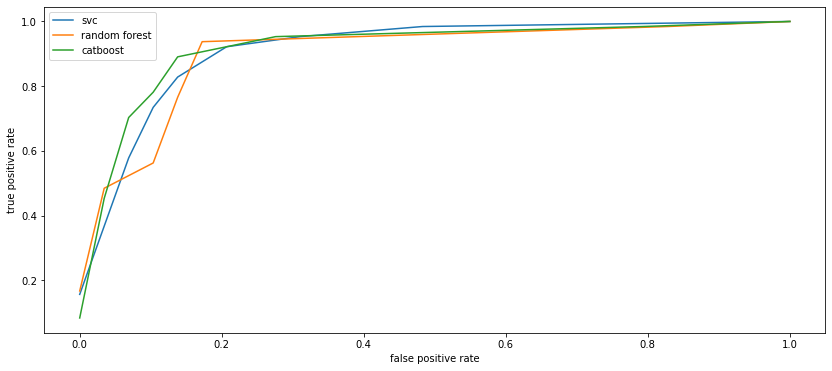

In [1152]:
plt.figure(figsize=(14,6))
sns.lineplot(x=fpr_svc, y=tpr_svc, ci=None, label='svc')
sns.lineplot(x=fpr_rf, y=tpr_rf, ci=None, label='random forest')
sns.lineplot(x=fpr_catboost, y=tpr_catboost, ci=None, label='catboost')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend()
plt.show()

Let's calculate areas under the curves.

In [1153]:
roc_auc_svc_test = roc_auc_score(target_test, svc_pred_prob)
roc_auc_svc_test

0.9245689655172413

In [1154]:
roc_auc_rf_test = roc_auc_score(target_test, rf_pred_prob)
roc_auc_rf_test

0.9105603448275862

In [1155]:
roc_auc_catboost_test = roc_auc_score(y_test, catboost_pred_prob)
roc_auc_catboost_test

0.9224137931034483

SVC and catboost show similar performance. They both outperformed the Random Forest.

In [1156]:
results_cv['roc_auc on the test set'] = pd.Series([roc_auc_svc_test, roc_auc_rf_test, roc_auc_catboost_test])

### Final table of results

In [1157]:
results_cv

,model,f1-score on cross-validation,f1-score on the test set,roc_auc on the test set
0,svm,0.832519,0.878788,0.924569
1,random forest,0.852917,0.878788,0.910560
2,catboost,0.857366,0.892308,0.922414


- Taking into account the both considered metrics, we can conclude that CatBoost showed the best result. 

## Feature importance

Let's have a look at the feature importances of the final model.

In [1158]:
final_importance = pd.concat([pd.Series(X_train.columns), 
                              pd.Series(best_catboost.feature_importances_)], axis=1)
final_importance.columns = ['feature', 'importance']
final_importance = final_importance.sort_values(by='importance', ascending=False)
final_importance

,feature,importance
11,thall,31.847864
2,cp,19.067052
10,caa,13.969756
9,slp,7.332575
7,exng,7.090327
16,cat_sum,4.624429
8,oldpeak,3.624839
5,restecg,2.029442
14,cholesterol_cat,1.947833
13,blood_pres_cat,1.631036


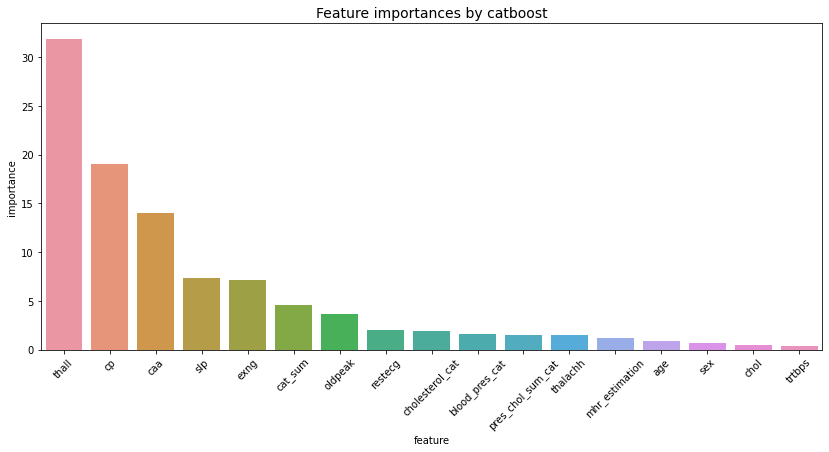

In [1159]:
plt.figure(figsize=(14,6))
sns.barplot(data=final_importance, x='feature', y='importance')
plt.xticks(rotation=45)
plt.title('Feature importances by catboost', fontsize=14)
plt.show()

- The most important features are thallium stress test, chest pain type, and number of major vessels.
- The less important features are sex, cholesterol, and resting blood pressure.